In [1]:
!pip install mitsuba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 43.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import io
import tempfile
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import drjit as dr
import mitsuba as mi
print(mi.variants())
mi.set_variant("cuda_ad_rgb")

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


In [3]:
n_rays    = 50
theta_max = np.deg2rad(20.0)

*Create mesh*

In [4]:
vertices = np.array([
    [-1.0, -1.0, 0.0],
    [ 1.0, -1.0, 0.0],
    [ 1.0,  1.0, 0.0],
    [-1.0,  1.0, 0.0],
], dtype=np.float32)

faces = np.array([
    [0, 1, 2],
    [0, 2, 3]
], dtype=np.int32)

*Create PLY string to be saved*

In [5]:
def create_ply_content(vertices, faces):
    """Create the content of a PLY file in ASCII format."""
    ply_content = io.StringIO()

    # Header PLY
    ply_content.write("ply\n")
    ply_content.write("format ascii 1.0\n")
    ply_content.write(f"element vertex {len(vertices)}\n")
    ply_content.write("property float x\n")
    ply_content.write("property float y\n")
    ply_content.write("property float z\n")
    ply_content.write(f"element face {len(faces)}\n")
    ply_content.write("property list uchar int vertex_index\n")
    ply_content.write("end_header\n")

    # Vertices
    for v in vertices:
        ply_content.write(f"{v[0]} {v[1]} {v[2]}\n")

    # Faces (triangles)
    for f in faces:
        ply_content.write(f"3 {f[0]} {f[1]} {f[2]}\n")

    return ply_content.getvalue()

# Generate the PLY string
ply_content = create_ply_content(vertices, faces)

*Write a file with the PLY mesh*

In [6]:
with tempfile.NamedTemporaryFile(mode='w', suffix='.ply', delete=False) as f:
    f.write(ply_content)
    temp_file_path = f.name

*Create the scene*

In [7]:
scene_dict = {
    "type": "scene",
    "square": {
        "type": "ply",
        "filename": temp_file_path,
        "face_normals": True  # Use vertex normals from file
    }
}

scene = mi.load_dict(scene_dict)

*Ray origin*

In [8]:
origin = mi.Point3f(0.0, 0.0, 2.0)

*Angular (theta, phi) sampling for ray launching*

In [9]:
def sample_cone_directions_batch(n_rays, theta_max):
    """Generate ray directions in batch for GPU optimization."""
    # Generate random numbers in batch
    u1 = np.random.rand(n_rays).astype(np.float32)
    u2 = np.random.rand(n_rays).astype(np.float32)

    # Convert to Mitsuba arrays for GPU processing
    u1_mi = mi.Float(u1)
    u2_mi = mi.Float(u2)

    # Vectorized spherical coordinate calculations
    cos_theta = 1.0 - u1_mi * (1.0 - dr.cos(theta_max))
    sin_theta = dr.sqrt(1.0 - cos_theta * cos_theta)
    phi = 2.0 * dr.pi * u2_mi

    # Convert to Cartesian coordinates
    x = sin_theta * dr.cos(phi)
    y = sin_theta * dr.sin(phi)
    z = -cos_theta  # Negative for downward cone

    # Create vector array (batch of directions)
    directions = mi.Vector3f(x, y, z)

    # Normalize all directions at once
    directions = dr.normalize(directions)

    return directions

# Number of rays and cone angle

# Generate directions in batch
directions = sample_cone_directions_batch(n_rays, theta_max)

*Batch ray tracing - first first intersections*

In [10]:
# Create all rays in batch
ray_origins   = mi.Point3f(origin)
ray_origins   = dr.repeat(ray_origins, n_rays)

# Create ray batch
rays          = mi.Ray3f(ray_origins, directions)
rays.maxt     = mi.Float(np.inf)

# Batch intersection test
intersections = scene.ray_intersect(rays)

# Process results
valid_mask    = intersections.is_valid()
hit_points    = intersections.p

*Reflected rays*

In [11]:
# FIX: Get normals and ensure they're valid
normals       = intersections.n
# Normalize normals (some might be zero-length)
normal_length = dr.sqrt(dr.squared_norm(normals))
# Replace zero-length normals with default up vector
normals       = dr.select(normal_length > 1e-6, dr.normalize(normals), mi.Vector3f(0.0, 0.0, 1.0))

# Compute reflected directions (vectorized)
reflected_dirs = directions - 2.0 * dr.dot(directions, normals) * normals
reflected_dirs = dr.normalize(reflected_dirs)

# Create reflected rays
reflected_ray_origins = hit_points + 1e-4 * normals
reflected_rays        = mi.Ray3f(reflected_ray_origins, reflected_dirs)
reflected_rays.maxt   = mi.Float(np.inf)

*Print some results*

In [12]:
print_results = 10
print(f"\nFirst {print_results} ray results:")

# Get numpy arrays and reshape
directions_np = np.array(directions).reshape(-1, 3)
hit_points_np = np.array(hit_points).reshape(-1, 3)
normals_np = np.array(normals).reshape(-1, 3)
reflected_dirs_np = np.array(reflected_dirs).reshape(-1, 3)
valid_mask_np = np.array(valid_mask)

for i in range(min(print_results, n_rays)):
    print(f"\nRay {i}:")
    if not valid_mask_np[i]:
        print("  No intersection")
        continue

    print(f"  HIT")
    print(f"  Direction   : [{directions_np[i, 0]:.4f}, {directions_np[i, 1]:.4f}, {directions_np[i, 2]:.4f}]")
    print(f"  Hit point   : [{hit_points_np[i, 0]:.4f}, {hit_points_np[i, 1]:.4f}, {hit_points_np[i, 2]:.4f}]")
    print(f"  Normal      : [{normals_np[i, 0]:.4f}, {normals_np[i, 1]:.4f}, {normals_np[i, 2]:.4f}]")

    # Show reflection physics
    dot_product = np.dot(directions_np[i], normals_np[i])
    print(f"  Dot product : {dot_product:.4f}")
    print(f"  Reflection  : [{reflected_dirs_np[i, 0]:.4f}, {reflected_dirs_np[i, 1]:.4f}, {reflected_dirs_np[i, 2]:.4f}]")



First 10 ray results:

Ray 0:
  HIT
  Direction   : [-0.0775, -0.3343, 0.1698]
  Hit point   : [-0.1567, -0.7108, 0.3485]
  Normal      : [0.0000, 0.0000, 0.0000]
  Dot product : 0.0000
  Reflection  : [-0.0775, -0.3343, 0.1698]

Ray 1:
  HIT
  Direction   : [0.0621, 0.1507, -0.1001]
  Hit point   : [0.1287, 0.3060, -0.2013]
  Normal      : [0.0000, 0.0000, 0.0000]
  Dot product : 0.0000
  Reflection  : [0.0621, 0.1507, -0.1001]

Ray 2:
  HIT
  Direction   : [-0.0654, -0.0173, -0.0996]
  Hit point   : [-0.1345, -0.0355, -0.2013]
  Normal      : [0.0000, 0.0000, 0.0000]
  Dot product : 0.0000
  Reflection  : [-0.0654, -0.0173, -0.0996]

Ray 3:
  HIT
  Direction   : [0.0705, -0.2386, -0.1020]
  Hit point   : [0.1463, -0.4969, -0.2059]
  Normal      : [0.0000, 0.0000, 0.0000]
  Dot product : 0.0000
  Reflection  : [0.0705, -0.2386, -0.1020]

Ray 4:
  HIT
  Direction   : [0.2427, -0.1220, 0.1157]
  Hit point   : [0.5131, -0.2590, 0.2332]
  Normal      : [0.0000, 0.0000, 0.0000]
  Dot prod

*Statistics*

In [13]:
# FIX: Convert drjit scalar to Python int
valid_count_scalar = dr.sum(dr.select(valid_mask, 1, 0))
valid_count = int(valid_count_scalar[0]) if hasattr(valid_count_scalar, '__getitem__') else int(valid_count_scalar)

print(f"\n=== Statistics ===")
print(f"Total rays: {n_rays}")
print(f"Intersections: {valid_count}")
print(f"Misses: {n_rays - valid_count}")
print(f"Hit rate: {valid_count/n_rays*100:.1f}%")

# Second bounce intersections
second_intersections = scene.ray_intersect(reflected_rays)
second_valid_mask = second_intersections.is_valid()
second_valid_count_scalar = dr.sum(dr.select(second_valid_mask, 1, 0))
second_valid_count = int(second_valid_count_scalar[0]) if hasattr(second_valid_count_scalar, '__getitem__') else int(second_valid_count_scalar)
print(f"Second bounce hits: {second_valid_count}")


=== Statistics ===
Total rays: 50
Intersections: 50
Misses: 0
Hit rate: 100.0%
Second bounce hits: 0


*Remove temporary file*

In [14]:
os.unlink(temp_file_path)

print("\nDone! GPU ray tracing completed successfully.")


Done! GPU ray tracing completed successfully.


*Visualization*

Final array shapes:
 directions      : (50, 3)
 hit_points      : (50, 3)
 normals         : (50, 3)
 reflected_dirs  : (50, 3)
 valid_mask      : (50,)
Valid intersections: 50


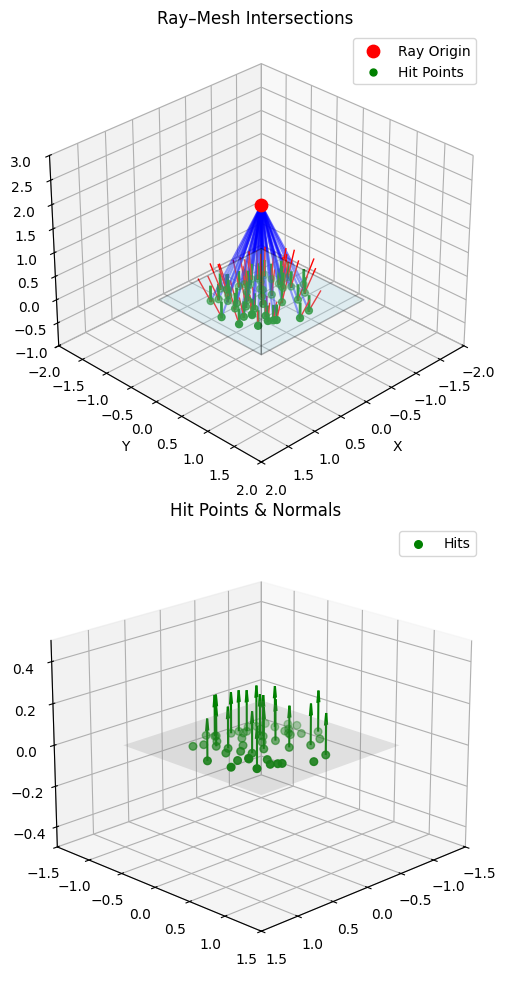

In [17]:
# ============================================================
# Robust 3D visualization with automatic shape correction
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ------------------------------------------------------------
# 1. Helper: force array into (N, 3)
# ------------------------------------------------------------

def force_Nx3(arr, name):
    arr = np.asarray(arr, dtype=float)

    # Case: flat array (3N,)
    if arr.ndim == 1 and arr.size % 3 == 0:
        arr = arr.reshape(-1, 3)

    # Case: (3, N) → transpose
    elif arr.ndim == 2 and arr.shape[0] == 3 and arr.shape[1] != 3:
        arr = arr.T

    # Case: (N, 1, 3) or (1, N, 3)
    elif arr.ndim == 3:
        arr = arr.reshape(-1, 3)

    if arr.ndim != 2 or arr.shape[1] != 3:
        raise ValueError(f"{name} cannot be coerced to shape (N, 3), got {arr.shape}")

    return arr


# ------------------------------------------------------------
# 2. Convert and FIX all arrays
# ------------------------------------------------------------

directions_np     = force_Nx3(directions, "directions")
hit_points_np     = force_Nx3(hit_points, "hit_points")
normals_np        = force_Nx3(normals, "normals")
reflected_dirs_np = force_Nx3(reflected_dirs, "reflected_dirs")

valid_mask_np = np.asarray(valid_mask, dtype=bool).reshape(-1)

# ------------------------------------------------------------
# 3. Enforce consistent ray count
# ------------------------------------------------------------

n_rays = min(
    directions_np.shape[0],
    hit_points_np.shape[0],
    normals_np.shape[0],
    reflected_dirs_np.shape[0],
    valid_mask_np.shape[0],
)

directions_np     = directions_np[:n_rays]
hit_points_np     = hit_points_np[:n_rays]
normals_np        = normals_np[:n_rays]
reflected_dirs_np = reflected_dirs_np[:n_rays]
valid_mask_np     = valid_mask_np[:n_rays]

print("Final array shapes:")
print(" directions      :", directions_np.shape)
print(" hit_points      :", hit_points_np.shape)
print(" normals         :", normals_np.shape)
print(" reflected_dirs  :", reflected_dirs_np.shape)
print(" valid_mask      :", valid_mask_np.shape)

# ------------------------------------------------------------
# 4. Keep only VALID hits
# ------------------------------------------------------------

valid_idx = np.where(valid_mask_np)[0]

hit_v     = hit_points_np[valid_idx]
normals_v = normals_np[valid_idx]
refl_v    = reflected_dirs_np[valid_idx]

print(f"Valid intersections: {hit_v.shape[0]}")

# ------------------------------------------------------------
# 5. Visualization
# ------------------------------------------------------------

origin_np = np.array([0.0, 0.0, 2.0])

fig = plt.figure(figsize=(18, 10))

# ======================= Overview ===========================

ax1 = fig.add_subplot(231, projection='3d')
ax1.set_title('Ray–Mesh Intersections')

mesh_triangles = [vertices[f] for f in faces]
mesh = Poly3DCollection(mesh_triangles, alpha=0.3, facecolor='lightblue', edgecolor='k')
ax1.add_collection3d(mesh)

ax1.scatter(*origin_np, color='red', s=80, label='Ray Origin')

if hit_v.size > 0:
    ax1.scatter(hit_v[:,0], hit_v[:,1], hit_v[:,2],
                color='green', s=25, label='Hit Points')

#for i in range(min(10, hit_v.shape[0])):
for i in range(hit_v.shape[0]):

    # Incident ray
    ax1.plot(
        [origin_np[0], hit_v[i,0]],
        [origin_np[1], hit_v[i,1]],
        [origin_np[2], hit_v[i,2]],
        'b-', alpha=0.5
    )

    # Normal
    ax1.plot(
        [hit_v[i,0], hit_v[i,0] + 0.3*normals_v[i,0]],
        [hit_v[i,1], hit_v[i,1] + 0.3*normals_v[i,1]],
        [hit_v[i,2], hit_v[i,2] + 0.3*normals_v[i,2]],
        'g-', linewidth=2
    )

    # Reflected ray
    ax1.plot(
        [hit_v[i,0], hit_v[i,0] + 0.5*refl_v[i,0]],
        [hit_v[i,1], hit_v[i,1] + 0.5*refl_v[i,1]],
        [hit_v[i,2], hit_v[i,2] + 0.5*refl_v[i,2]],
        'r-', linewidth=1
    )

ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax1.set_zlim([-1, 3])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.view_init(30, 45)

# ===================== Close-up ==============================

ax2 = fig.add_subplot(234, projection='3d')
ax2.set_title('Hit Points & Normals')

ax2.add_collection3d(
    Poly3DCollection(mesh_triangles, alpha=0.2, facecolor='gray')
)

if hit_v.size > 0:
    ax2.scatter(hit_v[:,0], hit_v[:,1], hit_v[:,2],
                color='green', s=30, label='Hits')

for i in range(min(20, hit_v.shape[0])):
    ax2.quiver(
        hit_v[i,0], hit_v[i,1], hit_v[i,2],
        normals_v[i,0], normals_v[i,1], normals_v[i,2],
        length=0.2, color='green'
    )

ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1.5, 1.5])
ax2.set_zlim([-0.5, 0.5])
ax2.legend()
ax2.view_init(20, 45)

plt.tight_layout()
plt.show()
